In [23]:
!pip install geopandas

     ---------------------------------------- 1.1/1.1 MB 17.4 MB/s eta 0:00:00
     ---------------------------------------- 6.1/6.1 MB 48.6 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 30.4 MB/s eta 0:00:00
     --------------------------------------- 22.9/22.9 MB 36.4 MB/s eta 0:00:00


In [973]:
import pandas as pd
import re
import json
import requests
import folium
from folium.plugins import HeatMap, HeatMapWithTime
from geopandas import gpd
from folium import Circle
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [298]:
data_20_23 = pd.read_csv('C:/Users/sjhty/Downloads/monthly_passengers_20_23.csv')
data_10_16 = pd.read_csv('C:/Users/sjhty/Downloads/monthly_passengers_10_16.csv')
data_2017 = pd.read_excel('C:/Users/sjhty/Downloads/서울교통공사 2017년 일별 역별 시간대별 승하차인원(1_8호선).xlsx', header=1)
data_2018 = pd.read_excel('C:/Users/sjhty/Downloads/서울교통공사 2018년 일별 역별 시간대별 승하차인원(1_8호선).xlsx', header=1)
data_2019 = pd.read_excel('C:/Users/sjhty/Downloads/서울교통공사 2019년 일별 역별 시간대별 승하차인원(1_8호선).xlsx', header=1)

In [299]:
data_2019['날짜'] = data_2019['날짜'].apply(lambda n:n.strftime('%Y-%m'))
data_2019 = data_2019[['역명', '날짜', '합 계']].groupby(['역명', '날짜']).sum().reset_index()
data_2018['날짜'] = data_2018['날짜'].apply(lambda n:n.strftime('%Y-%m'))
data_2018 = data_2018[['역명', '날짜', '합 계']].groupby(['역명', '날짜']).sum().reset_index()
data_2017['날짜'] = data_2017['날짜'].apply(lambda n:pd.to_datetime(n).strftime('%Y-%m'))
data_2017 = data_2017[['역명', '날짜', '합 계']].groupby(['역명', '날짜']).sum().reset_index()

data_17_19 = pd.concat([data_2017, data_2018, data_2019], axis=0)
data_17_19.columns = ['역명', '연월', '총 승하차 인원']

In [300]:
data_10_16['역명'] = data_10_16['역명'].apply(lambda n:n.split('(')[0])
data_17_19['역명'] = data_17_19['역명'].apply(lambda n:n.split('(')[0])
data_20_23['역명'] = data_20_23['역명'].apply(lambda n:n.split('(')[0])

In [301]:
data_10_23 = pd.concat([data_10_16, data_17_19, data_20_23], axis=0)

In [302]:
data_10_23['역명'] = data_10_23['역명'].apply(lambda n:re.sub('동대문역사문화공원5', '동대문역사문화공원', n))
data_10_23['역명'] = data_10_23['역명'].apply(lambda n:re.sub('미아삼거리', '미아사거리', n))


## 지하철 위도, 경도 정보 가져오기

In [234]:
auth_key = '70e4b8cf-72cf-48fd-ad64-5230451fa045'
url = 'http://t-data.seoul.go.kr/apig/apiman-gateway/tapi/TaimsKsccDvSubwayStationGeom/1.0'

params = {
    'apikey': auth_key,
    'startRow': '1',
    'rowCnt': '1000'
}

response = requests.get(url, params=params)
data = response.json()

#### 같은 역 이름으로 호선이 다른 경우 좌표가 두 개 생김, 향후 사용한다면 해당 부분 수정 필요

In [305]:
name = []
longitude = []
latitude = []

for i in data:
    name.append(i['stnKrNm'])
    longitude.append(i['convX'])
    latitude.append(i['convY'])
    
sb_location = pd.DataFrame(
    {'name':name,
    'longitude':longitude,
    'latitude':latitude}
)

### 지하철 유동인구에 따른 가게들의 오픈, 폐업, 현재 엽엉중을 살펴보자

In [318]:
sb_location['name'] = sb_location['name'].apply(lambda n:n.split('(')[0])
sb_location.drop_duplicates(subset=['name'], keep='first', inplace=True)
sb_data_lc = pd.merge(data_10_23, sb_location, how='left', left_on='역명', right_on='name').drop(['name'], axis=1)

```sql
SELECT date
  , ARRAY_AGG(name) AS name
  , ARRAY_AGG(longitude) AS longitude
  , ARRAY_AGG(latitude) AS latitude
FROM `temp.sb_data`
GROUP BY date
```

In [155]:
st_data_lc = pd.read_csv('sb_data_1차.csv')

In [182]:
df = pd.read_csv('C:/Users/sjhty/Desktop/SHoon/gcp/pjt/store_keyword.csv')

In [184]:
df['store_name'] = df['store_name'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['total_location'] = df['total_location'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['normal_location'] = df['normal_location'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['close_location'] = df['close_location'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['open_date'] = df['open_date'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['close_date'] = df['close_date'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)

In [183]:
st_data_lc['name'] = st_data_lc['name'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
st_data_lc['longitude'] = st_data_lc['longitude'].apply(lambda n: [float(i) for i in n.strip('[]').split(',') if n not in ['[],', '[]']])
st_data_lc['latitude'] = st_data_lc['latitude'].apply(lambda n: [float(i) for i in n.strip('[]').split(',') if n not in ['[],', '[]']])
st_data_lc['population'] = st_data_lc['population'].apply(lambda n: [float(i) for i in n.strip('[]').split(',') if n not in ['[],', '[]']])
st_data_lc['normalized_population'] = st_data_lc['normalized_population'].apply(lambda n: [float(i) for i in n.strip('[]').split(',') if n not in ['[],', '[]']])

AttributeError: 'list' object has no attribute 'strip'

In [178]:

# Folium 지도 생성
m = folium.Map(location=[37.55, 127], zoom_start=12)

# 승하차 인원을 기준으로 HeatMap 그리기
heat_data = []
for idx, row in st_data_lc.iterrows():
    heat_data.append(list(zip(row['latitude'], row['longitude'], row['normalized_population'])))
    
for i in range(len(heat_data)):
    for j in range(len(heat_data[i])):
        heat_data[i][j] = list(heat_data[i][j])

hm = HeatMapWithTime(heat_data, index=st_data_lc['date'].tolist(), auto_play=True, max_opacity=1, blur=0.05, radius=15, max_speed=60)
hm.add_to(m)

In [818]:
boom = {
    '명랑핫도그':pd.to_datetime('2017.04')
    , '설빙':pd.to_datetime('2014.08')
    , '공차':pd.to_datetime('2014.05')
    , '마라탕':pd.to_datetime('2019.09')
    , '엽기떡볶이':pd.to_datetime('2015.05')
    , '카스테라':pd.to_datetime('2017.01')
    , '쥬씨':pd.to_datetime('2016.07')
    , '엉생':pd.to_datetime('2016.06')
    , '홍루이젠':pd.to_datetime('2018.09')
    , '밥버거':pd.to_datetime('2013.11')
    , '탕후루':pd.to_datetime('2023.10')
}

In [326]:
sb_data_n10 = pd.read_csv('C:/Users/sjhty/Desktop/데이터/sb_data_n10.csv')
sb_data_not_n10 = pd.read_csv('C:/Users/sjhty/Desktop/데이터/sb_data_not_n10.csv')

In [327]:
sb_data_n10['licence_date'] = pd.to_datetime(sb_data_n10['licence_date'])
sb_data_n10['close_date'] = pd.to_datetime(sb_data_n10['close_date'])

sb_data_not_n10['licence_date'] = pd.to_datetime(sb_data_not_n10['licence_date'])
sb_data_not_n10['close_date'] = pd.to_datetime(sb_data_not_n10['close_date'])

### 역 근처, 근처 아닌 데이터들을 boom 기준으로 나누어주기

In [328]:
sb_data_n10_steady_before = sb_data_n10[(sb_data_n10['keyword']=='명랑핫도그')& (sb_data_n10['licence_date']<boom['명랑핫도그']) 
            | (sb_data_n10['keyword']=='설빙')& (sb_data_n10['licence_date']<boom['설빙'])
           | (sb_data_n10['keyword']=='공차')& (sb_data_n10['licence_date']<boom['공차'])
           | (sb_data_n10['keyword']=='마라탕')& (sb_data_n10['licence_date']<boom['마라탕'])
           | (sb_data_n10['keyword']=='엽기떡볶이')& (sb_data_n10['licence_date']<boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_n10_steady_after = sb_data_n10[(sb_data_n10['keyword']=='명랑핫도그')& (sb_data_n10['licence_date']>=boom['명랑핫도그']) 
            | (sb_data_n10['keyword']=='설빙')& (sb_data_n10['licence_date']>=boom['설빙'])
           | (sb_data_n10['keyword']=='공차')& (sb_data_n10['licence_date']>=boom['공차'])
           | (sb_data_n10['keyword']=='마라탕')& (sb_data_n10['licence_date']>=boom['마라탕'])
           | (sb_data_n10['keyword']=='엽기떡볶이')& (sb_data_n10['licence_date']>=boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_n10_trendy_before = sb_data_n10[(sb_data_n10['keyword']=='카스테라')& (sb_data_n10['licence_date']<boom['카스테라']) 
            | (sb_data_n10['keyword']=='쥬씨')& (sb_data_n10['licence_date']<boom['쥬씨'])
           | (sb_data_n10['keyword']=='엉생')& (sb_data_n10['licence_date']<boom['엉생'])
           | (sb_data_n10['keyword']=='홍루이젠')& (sb_data_n10['licence_date']<boom['홍루이젠'])
           | (sb_data_n10['keyword']=='밥버거')& (sb_data_n10['licence_date']<boom['밥버거'])].reset_index(drop=True)

sb_data_n10_trendy_after = sb_data_n10[(sb_data_n10['keyword']=='카스테라')& (sb_data_n10['licence_date']>=boom['카스테라']) 
            | (sb_data_n10['keyword']=='쥬씨')& (sb_data_n10['licence_date']>=boom['쥬씨'])
           | (sb_data_n10['keyword']=='엉생')& (sb_data_n10['licence_date']>=boom['엉생'])
           | (sb_data_n10['keyword']=='홍루이젠')& (sb_data_n10['licence_date']>=boom['홍루이젠'])
           | (sb_data_n10['keyword']=='밥버거')& (sb_data_n10['licence_date']>=boom['밥버거'])].reset_index(drop=True)

In [329]:
sb_data_not_n10_steady_before = sb_data_not_n10[(sb_data_not_n10['keyword']=='명랑핫도그')& (sb_data_not_n10['licence_date']<boom['명랑핫도그']) 
            | (sb_data_not_n10['keyword']=='설빙')& (sb_data_not_n10['licence_date']<boom['설빙'])
           | (sb_data_not_n10['keyword']=='공차')& (sb_data_not_n10['licence_date']<boom['공차'])
           | (sb_data_not_n10['keyword']=='마라탕')& (sb_data_not_n10['licence_date']<boom['마라탕'])
           | (sb_data_not_n10['keyword']=='엽기떡볶이')& (sb_data_not_n10['licence_date']<boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_not_n10_steady_after = sb_data_not_n10[(sb_data_not_n10['keyword']=='명랑핫도그')& (sb_data_not_n10['licence_date']>=boom['명랑핫도그']) 
            | (sb_data_not_n10['keyword']=='설빙')& (sb_data_not_n10['licence_date']>=boom['설빙'])
           | (sb_data_not_n10['keyword']=='공차')& (sb_data_not_n10['licence_date']>=boom['공차'])
           | (sb_data_not_n10['keyword']=='마라탕')& (sb_data_not_n10['licence_date']>=boom['마라탕'])
           | (sb_data_not_n10['keyword']=='엽기떡볶이')& (sb_data_not_n10['licence_date']>=boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_not_n10_trendy_before = sb_data_not_n10[(sb_data_not_n10['keyword']=='카스테라')& (sb_data_not_n10['licence_date']<boom['카스테라']) 
            | (sb_data_not_n10['keyword']=='쥬씨')& (sb_data_not_n10['licence_date']<boom['쥬씨'])
           | (sb_data_not_n10['keyword']=='엉생')& (sb_data_not_n10['licence_date']<boom['엉생'])
           | (sb_data_not_n10['keyword']=='홍루이젠')& (sb_data_not_n10['licence_date']<boom['홍루이젠'])
           | (sb_data_not_n10['keyword']=='밥버거')& (sb_data_not_n10['licence_date']<boom['밥버거'])].reset_index(drop=True)

sb_data_not_n10_trendy_after = sb_data_not_n10[(sb_data_not_n10['keyword']=='카스테라')& (sb_data_not_n10['licence_date']>=boom['카스테라']) 
            | (sb_data_not_n10['keyword']=='쥬씨')& (sb_data_not_n10['licence_date']>=boom['쥬씨'])
           | (sb_data_not_n10['keyword']=='엉생')& (sb_data_not_n10['licence_date']>=boom['엉생'])
           | (sb_data_not_n10['keyword']=='홍루이젠')& (sb_data_not_n10['licence_date']>=boom['홍루이젠'])
           | (sb_data_not_n10['keyword']=='밥버거')& (sb_data_not_n10['licence_date']>=boom['밥버거'])].reset_index(drop=True)

### 붐, 이전 이후 status (폐업 상태) 변경하기
* 붐 이전만 바꾸어주면 됨

In [330]:
for idx, data in sb_data_n10_steady_before.iterrows():
    if data['close_date'] < boom[data['keyword']]:
        sb_data_n10_steady_before.loc[idx,'status'] = '폐업'
    else:
        sb_data_n10_steady_before.loc[idx,'status'] = '영업/정상'

In [331]:
for idx, data in sb_data_n10_trendy_before.iterrows():
    if data['close_date'] < boom[data['keyword']]:
        sb_data_n10_steady_before.loc[idx,'status'] = '폐업'
    else:
        sb_data_n10_steady_before.loc[idx,'status'] = '영업/정상'

In [332]:
for idx, data in sb_data_not_n10_steady_before.iterrows():
    if data['close_date'] < boom[data['keyword']]:
        sb_data_not_n10_steady_before.loc[idx,'status'] = '폐업'
    else:
        sb_data_not_n10_steady_before.loc[idx,'status'] = '영업/정상'

In [333]:
for idx, data in sb_data_not_n10_trendy_before.iterrows():
    if data['close_date'] < boom[data['keyword']]:
        sb_data_not_n10_steady_before.loc[idx,'status'] = '폐업'
    else:
        sb_data_not_n10_steady_before.loc[idx,'status'] = '영업/정상'

In [334]:
sb_data_n10['status'].value_counts()

영업/정상    186
폐업       148
Name: status, dtype: int64

In [335]:
sb_data_n10_steady_before['status'].value_counts()

영업/정상    91
폐업        7
Name: status, dtype: int64

In [336]:
sb_data_n10_steady_after['status'].value_counts()

영업/정상    84
폐업       35
Name: status, dtype: int64

In [337]:
sb_data_n10_trendy_before['status'].value_counts()


폐업       34
영업/정상     7
Name: status, dtype: int64

In [338]:
sb_data_n10_trendy_after['status'].value_counts()

폐업       19
영업/정상     9
Name: status, dtype: int64

### not 경계선

In [345]:
sb_data_not_n10_steady_before['status'].value_counts()


영업/정상    416
폐업         6
Name: status, dtype: int64

In [346]:
sb_data_not_n10_steady_after['status'].value_counts()

영업/정상    588
폐업       173
Name: status, dtype: int64

In [347]:
sb_data_not_n10_trendy_before['status'].value_counts()

폐업       191
영업/정상     85
Name: status, dtype: int64

In [348]:
sb_data_not_n10_trendy_after['status'].value_counts()

폐업       154
영업/정상     78
Name: status, dtype: int64

0.27689243027888444

In [21]:
sb_data_n10_trendy

,int64_field_0,licence_date,licence_cancel_date,status,close_date,location_number_address,street_name_address,store_name,category,longitude,...,multi_business,period,keyword,class,name,avg_population,latitude_1,longitude_1,quartile,ROW
0,2257130,2016-02-24,NaN,폐업,2021-06-08,서울특별시 광진구 구의동 546-1 1층105호,"서울특별시 광진구 강변역로 50, 1층 105호 (구의동)",쥬씨동서울터미널점,기타 휴게음식점,127.090695,...,False,1931 days,쥬씨,trendy,강변,2.870143e+06,37.535095,127.094681,10,1
1,2514659,2016-05-31,NaN,영업/정상,2023-11-21,서울특별시 관악구 봉천동 888-35번지,"서울특별시 관악구 양녕로 44, 1층 (봉천동)",쥬씨 현대시장점,커피숍,126.944226,...,False,2730 days,쥬씨,trendy,서울대입구,3.218809e+06,37.481247,126.952739,10,1
2,2178801,2018-10-01,NaN,폐업,2023-08-02,서울특별시 구로구 신도림동 337 신도림1차푸르지오,"서울특별시 구로구 경인로 661, 신도림1차푸르지오 1층 161호 (신도림동)",홍루이젠 신도림역점,패스트푸드,126.884854,...,False,1766 days,홍루이젠,trendy,신도림,3.625087e+06,37.508961,126.891084,10,1
3,2308082,2017-01-18,NaN,폐업,2017-09-21,서울특별시 송파구 방이동 104-3번지,"서울특별시 송파구 오금로17길 7, 101호 (방이동)",대만대왕 카스테라 판다,기타 휴게음식점,127.108557,...,False,246 days,카스테라,trendy,잠실,3.730178e+06,37.514692,127.104338,10,1
4,719934,2014-04-28,NaN,폐업,2016-08-30,서울특별시 강남구 대치동 920-22번지 지상1층 101호,"서울특별시 강남구 역삼로64길 26, 지상1층 101호 (대치동)",뚱스 밥버거,분식,127.050424,...,False,855 days,밥버거,trendy,선릉,3.284806e+06,37.504856,127.048807,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,486722,2011-12-16,NaN,폐업,2013-02-28,서울특별시 관악구 봉천동 925-27번지 지상1층,"서울특별시 관악구 봉천로 385, 지상1층 (봉천동)",신엉터리생고기,한식,126.939914,...,False,440 days,엉터리생고기,trendy,신림,4.318712e+06,37.484201,126.929715,10,1
150,2151760,2014-10-30,NaN,폐업,2020-08-20,서울특별시 강남구 대치동 922,"서울특별시 강남구 선릉로 326, 1층 5호 (대치동)",봉구스밥버거,일반조리판매,127.049209,...,False,2121 days,밥버거,trendy,선릉,3.284806e+06,37.504856,127.048807,10,1
151,2258782,2013-10-28,NaN,폐업,2015-12-21,서울특별시 광진구 구의동 250-30번지 (1층),"서울특별시 광진구 자양로28길 12, 1층 (구의동)",봉구스 밥버거,일반조리판매,127.081984,...,False,784 days,밥버거,trendy,건대입구,2.513628e+06,37.540786,127.071011,10,1
152,2261448,2017-04-26,NaN,폐업,2017-05-15,서울특별시 강남구 삼성동 159번지,"서울특별시 강남구 영동대로 513, 지상1층 (삼성동, 코엑스 동측광장)",엉터리생고기,패스트푸드,127.055929,...,False,19 days,엉터리생고기,trendy,삼성,3.712045e+06,37.508844,127.063160,10,1


In [20]:
sb_data_not_n10_trendy

,int64_field_0,licence_date,licence_cancel_date,status,close_date,location_number_address,street_name_address,store_name,category,longitude,latitude,business_area_name,multi_business,period,keyword,class
0,1429128,2020-11-26,NaN,영업/정상,2023-11-21,서울특별시 양천구 신월동 986-8 용민아파트 1층 102호,"서울특별시 양천구 지양로 25, 1층 102호 (신월동, 용민아파트)",네네치킨 봉구스밥버거 신월3점,기타,126.834006,37.518666,NaN,False,1090 days,밥버거,trendy
1,851497,2015-01-23,NaN,폐업,2017-02-22,서울특별시 송파구 마천동 126-7번지 지상1층,"서울특별시 송파구 마천로41길 7, 지상1층 (마천동)",뚱스 밥버거,분식,127.145586,37.497264,NaN,False,761 days,밥버거,trendy
2,487707,2014-11-26,NaN,폐업,2017-07-04,서울특별시 관악구 봉천동 1718번지,"서울특별시 관악구 은천로 93, 502동 1층 101호 (봉천동, 벽산블루밍)",봉구스밥버거 봉천벽산점,분식,126.941877,37.489288,NaN,False,951 days,밥버거,trendy
3,844598,2014-02-05,NaN,폐업,2019-08-26,서울특별시 서대문구 충정로2가 115-13번지 1층,"서울특별시 서대문구 충정로 63, 1층 (충정로2가)",봉구스밥버거(서울경기대점),분식,126.962493,37.564560,NaN,False,2028 days,밥버거,trendy
4,144111,2014-04-11,NaN,폐업,2019-01-08,서울특별시 구로구 천왕동 27번지 천왕이펜하우스 3단지 상가동 101호,"서울특별시 구로구 천왕로 56 (천왕동, 천왕이펜하우스 3단지 상가동 101호)",뚱스밥버거 천왕점,분식,126.837279,37.482529,NaN,False,1733 days,밥버거,trendy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2403010,2019-01-25,NaN,폐업,2023-02-06,서울특별시 강북구 미아동 1364,"서울특별시 강북구 도봉로 52, 1층 (미아동)",쥬씨 미아와이스퀘어점,기타 휴게음식점,127.027624,37.613701,NaN,False,1473 days,쥬씨,trendy
475,2355921,2014-05-21,NaN,폐업,2016-02-15,서울특별시 양천구 목동 405-300번지 상가1층3호,"서울특별시 양천구 오목로54길 1, 1층 상가3호 (목동)",뚱스밥버거목동1호점,기타 휴게음식점,126.870570,37.524244,NaN,False,635 days,밥버거,trendy
476,2566377,2016-07-06,NaN,영업/정상,2023-11-21,서울특별시 용산구 보광동 231-43번지 1층,"서울특별시 용산구 보광로 45, 1층 (보광동)",쥬씨(보광점),기타 휴게음식점,126.996053,37.528102,NaN,False,2694 days,쥬씨,trendy
477,2590183,2018-06-27,NaN,영업/정상,2023-11-21,서울특별시 마포구 도화동 563번지 마포아크로타워,"서울특별시 마포구 마포대로 68, 1층 111호 (도화동, 마포아크로타워)",홍루이젠 마포역점,기타 휴게음식점,126.946100,37.541336,NaN,False,1973 days,홍루이젠,trendy


In [357]:
test = sb_data_n10[['name', 'latitude_1', 'longitude_1']].drop_duplicates(['latitude_1']).reset_index(drop=True)

In [325]:
test

,name,latitude_1,longitude_1
0,압구정,37.527072,127.028461
1,서울대입구,37.481247,126.952739
2,회현,37.558514,126.978246
3,가산디지털단지,37.480338,126.882656
4,동대문,37.570930,127.009287
5,대림,37.493243,126.894932
6,신도림,37.508961,126.891084
7,충무로,37.561207,126.994080
8,교대,37.493961,127.014667
9,신림,37.484201,126.929715


In [94]:
sb_data_n10_steady[['name', 'latitude_1', 'longitude_1']]

,name,latitude_1,longitude_1
0,을지로입구,37.566014,126.982618
1,홍대입구,37.557641,126.926683
2,혜화,37.582336,127.001844
3,서울대입구,37.481247,126.952739
4,수유,37.638052,127.025732
...,...,...,...
436,잠실,37.514692,127.104338
437,서울대입구,37.481247,126.952739
438,서울대입구,37.481247,126.952739
439,수유,37.638052,127.025732


In [364]:
temp=pd.concat([sb_data_n10, sb_data_not_n10], axis=0)

In [368]:
temp[temp['class']!='tang'][['store_name', 'latitude', 'longitude']]

,store_name,latitude,longitude
0,단수이대왕카스테라 신도림디큐브점,37.508585,126.886008
1,불닭발동대문엽기떡볶이 신림점,37.487007,126.924394
2,(주)공차코리아(글라스타워점),37.499033,127.024775
4,공차 낙성대역점,37.478222,126.958480
5,봉구스밥버거 연세대점,37.558861,126.933582
...,...,...,...
1976,따호카스테라,37.654874,127.059045
1977,공차 (전농동 사거리점),37.577514,127.054318
1979,공차 동대문종합시장점,37.570174,127.005315
1980,공차왕십리역사점,37.561289,127.035492


In [391]:
map_center = [37.5, 126.95]  # 서울 중심 좌표
m = folium.Map(location=map_center, zoom_start=12)

In [371]:
for index, location in test.iterrows():
    folium.Marker(location=[location['latitude_1'], location['longitude_1']], popup=location['name']).add_to(m)
    Circle(
        location=[location['latitude_1'], location['longitude_1']],
        radius=1000,
        color='black',
        fill=True,
        fill_color='white',  # 원 안은 흰색으로 설정하여 밝게 표시
        fill_opacity=0.6,
    ).add_to(m)

In [360]:
m

In [402]:
map_center = [37.5, 126.95]  # 서울 중심 좌표
m = folium.Map(location=map_center, zoom_start=12)

In [403]:
for index, location in sb_data_n10_trendy_before.iterrows():
    folium.Marker(location=[location['latitude'], location['longitude']]).add_to(m)

m

### 대도시 vs 소도시

In [414]:
sb_data_n10 = pd.read_csv('C:/Users/sjhty/Desktop/데이터/대도시.csv')
sb_data_not_n10 = pd.read_csv('C:/Users/sjhty/Desktop/데이터/소도시.csv')

In [416]:
sb_data_n10['licence_date'] = pd.to_datetime(sb_data_n10['licence_date'])
sb_data_n10['close_date'] = pd.to_datetime(sb_data_n10['close_date'])

sb_data_not_n10['licence_date'] = pd.to_datetime(sb_data_not_n10['licence_date'])
sb_data_not_n10['close_date'] = pd.to_datetime(sb_data_not_n10['close_date'])

In [417]:
sb_data_n10_steady_before = sb_data_n10[(sb_data_n10['keyword']=='명랑핫도그')& (sb_data_n10['licence_date']<boom['명랑핫도그']) 
            | (sb_data_n10['keyword']=='설빙')& (sb_data_n10['licence_date']<boom['설빙'])
           | (sb_data_n10['keyword']=='공차')& (sb_data_n10['licence_date']<boom['공차'])
           | (sb_data_n10['keyword']=='마라탕')& (sb_data_n10['licence_date']<boom['마라탕'])
           | (sb_data_n10['keyword']=='엽기떡볶이')& (sb_data_n10['licence_date']<boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_n10_steady_after = sb_data_n10[(sb_data_n10['keyword']=='명랑핫도그')& (sb_data_n10['licence_date']>=boom['명랑핫도그']) 
            | (sb_data_n10['keyword']=='설빙')& (sb_data_n10['licence_date']>=boom['설빙'])
           | (sb_data_n10['keyword']=='공차')& (sb_data_n10['licence_date']>=boom['공차'])
           | (sb_data_n10['keyword']=='마라탕')& (sb_data_n10['licence_date']>=boom['마라탕'])
           | (sb_data_n10['keyword']=='엽기떡볶이')& (sb_data_n10['licence_date']>=boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_n10_trendy_before = sb_data_n10[(sb_data_n10['keyword']=='카스테라')& (sb_data_n10['licence_date']<boom['카스테라']) 
            | (sb_data_n10['keyword']=='쥬씨')& (sb_data_n10['licence_date']<boom['쥬씨'])
           | (sb_data_n10['keyword']=='엉생')& (sb_data_n10['licence_date']<boom['엉생'])
           | (sb_data_n10['keyword']=='홍루이젠')& (sb_data_n10['licence_date']<boom['홍루이젠'])
           | (sb_data_n10['keyword']=='밥버거')& (sb_data_n10['licence_date']<boom['밥버거'])].reset_index(drop=True)

sb_data_n10_trendy_after = sb_data_n10[(sb_data_n10['keyword']=='카스테라')& (sb_data_n10['licence_date']>=boom['카스테라']) 
            | (sb_data_n10['keyword']=='쥬씨')& (sb_data_n10['licence_date']>=boom['쥬씨'])
           | (sb_data_n10['keyword']=='엉생')& (sb_data_n10['licence_date']>=boom['엉생'])
           | (sb_data_n10['keyword']=='홍루이젠')& (sb_data_n10['licence_date']>=boom['홍루이젠'])
           | (sb_data_n10['keyword']=='밥버거')& (sb_data_n10['licence_date']>=boom['밥버거'])].reset_index(drop=True)


In [418]:
sb_data_not_n10_steady_before = sb_data_not_n10[(sb_data_not_n10['keyword']=='명랑핫도그')& (sb_data_not_n10['licence_date']<boom['명랑핫도그']) 
            | (sb_data_not_n10['keyword']=='설빙')& (sb_data_not_n10['licence_date']<boom['설빙'])
           | (sb_data_not_n10['keyword']=='공차')& (sb_data_not_n10['licence_date']<boom['공차'])
           | (sb_data_not_n10['keyword']=='마라탕')& (sb_data_not_n10['licence_date']<boom['마라탕'])
           | (sb_data_not_n10['keyword']=='엽기떡볶이')& (sb_data_not_n10['licence_date']<boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_not_n10_steady_after = sb_data_not_n10[(sb_data_not_n10['keyword']=='명랑핫도그')& (sb_data_not_n10['licence_date']>=boom['명랑핫도그']) 
            | (sb_data_not_n10['keyword']=='설빙')& (sb_data_not_n10['licence_date']>=boom['설빙'])
           | (sb_data_not_n10['keyword']=='공차')& (sb_data_not_n10['licence_date']>=boom['공차'])
           | (sb_data_not_n10['keyword']=='마라탕')& (sb_data_not_n10['licence_date']>=boom['마라탕'])
           | (sb_data_not_n10['keyword']=='엽기떡볶이')& (sb_data_not_n10['licence_date']>=boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_not_n10_trendy_before = sb_data_not_n10[(sb_data_not_n10['keyword']=='카스테라')& (sb_data_not_n10['licence_date']<boom['카스테라']) 
            | (sb_data_not_n10['keyword']=='쥬씨')& (sb_data_not_n10['licence_date']<boom['쥬씨'])
           | (sb_data_not_n10['keyword']=='엉생')& (sb_data_not_n10['licence_date']<boom['엉생'])
           | (sb_data_not_n10['keyword']=='홍루이젠')& (sb_data_not_n10['licence_date']<boom['홍루이젠'])
           | (sb_data_not_n10['keyword']=='밥버거')& (sb_data_not_n10['licence_date']<boom['밥버거'])].reset_index(drop=True)

sb_data_not_n10_trendy_after = sb_data_not_n10[(sb_data_not_n10['keyword']=='카스테라')& (sb_data_not_n10['licence_date']>=boom['카스테라']) 
            | (sb_data_not_n10['keyword']=='쥬씨')& (sb_data_not_n10['licence_date']>=boom['쥬씨'])
           | (sb_data_not_n10['keyword']=='엉생')& (sb_data_not_n10['licence_date']>=boom['엉생'])
           | (sb_data_not_n10['keyword']=='홍루이젠')& (sb_data_not_n10['licence_date']>=boom['홍루이젠'])
           | (sb_data_not_n10['keyword']=='밥버거')& (sb_data_not_n10['licence_date']>=boom['밥버거'])].reset_index(drop=True)

In [420]:
sb_data_n10['status'].value_counts()

영업/정상    5669
폐업       2406
Name: status, dtype: int64

In [421]:
sb_data_n10_steady_before['status'].value_counts()

영업/정상    1129
폐업        517
Name: status, dtype: int64

In [422]:
sb_data_n10_steady_after['status'].value_counts()

영업/정상    2791
폐업        540
Name: status, dtype: int64

In [423]:
sb_data_n10_trendy_before['status'].value_counts()


폐업       669
영업/정상    269
Name: status, dtype: int64

In [424]:
sb_data_n10_trendy_after['status'].value_counts()

폐업       586
영업/정상    328
Name: status, dtype: int64

### not 경계선

In [429]:
sb_data_not_n10_steady_before['status'].value_counts()


영업/정상    435
폐업       110
Name: status, dtype: int64

In [430]:
sb_data_not_n10_steady_after['status'].value_counts()

영업/정상    1173
폐업        110
Name: status, dtype: int64

In [431]:
sb_data_not_n10_trendy_before['status'].value_counts()

폐업       190
영업/정상    118
Name: status, dtype: int64

In [432]:
sb_data_not_n10_trendy_after['status'].value_counts()

폐업       220
영업/정상    165
Name: status, dtype: int64

In [480]:
sb_data_not_n10_trendy_before[sb_data_not_n10_trendy_before['status']=='폐업']

,int64_field_0,licence_date,licence_cancel_date,status,close_date,location_number_address,street_name_address,store_name,category,longitude,latitude,business_area_name,multi_business,period,keyword,class
2,1233296,2013-01-29,NaN,폐업,2015-09-25,전라북도 전주시 완산구 평화동2가 339-7번지 103호,전라북도 전주시 완산구 소대배기로 11 (평화동2가),몬스터 밥버거,한식,127.128714,35.787566,기타,False,969 days,밥버거,trendy
3,1234096,2013-04-26,NaN,폐업,2023-08-14,전라북도 전주시 완산구 중화산동2가 655-8,전라북도 전주시 완산구 영경1길 16 (중화산동2가),봉구스밥버거(중화산점),한식,127.121669,35.817820,기타,False,3762 days,밥버거,trendy
4,1125227,2014-01-21,NaN,폐업,2016-10-12,강원특별자치도 춘천시 석사동 888-1 스타플러스빌딩 105호,"강원특별자치도 춘천시 퇴계농공로 11, 105호 (석사동, 스타플러스빌딩 )",쥬씨CGV점,한식,127.742189,37.851960,주택가주변,False,995 days,쥬씨,trendy
8,916877,2012-01-17,NaN,폐업,2020-11-02,"전라남도 순천시 용당동 560-3 (1,2층)","전라남도 순천시 삼산로 92, 1,2층 (용당동)",봉구스밥버거 용당점,통닭(치킨),127.490449,34.972677,NaN,False,3212 days,밥버거,trendy
9,215203,2011-05-25,NaN,폐업,2020-08-11,경상북도 칠곡군 왜관읍 왜관리 291-1,경상북도 칠곡군 왜관읍 중앙로 160,봉구스밥버거,패스트푸드,128.396814,35.989084,기타,False,3366 days,밥버거,trendy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,2392268,2012-09-27,NaN,폐업,2016-05-02,경상북도 경주시 충효동 2987-11번지,경상북도 경주시 충효3길 9 (충효동),봉구스밥버거 서라벌대점,기타 휴게음식점,129.182647,35.842558,NaN,False,1313 days,밥버거,trendy
303,2416843,2013-05-30,NaN,폐업,2021-04-19,전라북도 군산시 조촌동 491 삼성A 상가 104호,"전라북도 군산시 백릉로 162, 104동 (조촌동, 삼성A 상가 )",봉구스밥버거(조촌점),기타 휴게음식점,126.741570,35.975049,NaN,False,2881 days,밥버거,trendy
304,2368607,2016-12-08,NaN,폐업,2017-12-15,경상남도 진주시 대안동 19-16번지 1층일부,"경상남도 진주시 진양호로531번길 7 (대안동, 1층일부)",호우메이카스테라,기타 휴게음식점,128.080301,35.193509,주택가주변,False,372 days,카스테라,trendy
305,2335280,2016-12-05,NaN,폐업,2018-09-20,전라남도 무안군 무안읍 교촌리 1045-2번지,전라남도 무안군 무안읍 창포로 31,대만언니 카스테라,기타 휴게음식점,126.468358,34.988120,NaN,False,654 days,카스테라,trendy


In [477]:
map_center = [36.5, 128.00]  # 서울 중심 좌표
m = folium.Map(location=map_center, zoom_start=7)

for index, location in sb_data_not_n10_trendy_before.iterrows():
    folium.Marker(location=[location['latitude'], location['longitude']]).add_to(m)

### 폐업으로 살펴보자
* 조기 폐업?

In [510]:
sb_data_n10 = sb_data_n10[sb_data_n10['status']=='폐업']
sb_data_not_n10 = sb_data_not_n10[sb_data_not_n10['status']=='폐업']


In [511]:
sb_data_n10['period'] = sb_data_n10['period'].apply(lambda n:float(re.sub('[^0-9]', '', n)))
sb_data_not_n10['period'] = sb_data_not_n10['period'].apply(lambda n:float(re.sub('[^0-9]', '', n)))

In [512]:
sb_data_n10['licence_date'] = pd.to_datetime(sb_data_n10['licence_date'])
sb_data_n10['close_date'] = pd.to_datetime(sb_data_n10['close_date'])

sb_data_not_n10['licence_date'] = pd.to_datetime(sb_data_not_n10['licence_date'])
sb_data_not_n10['close_date'] = pd.to_datetime(sb_data_not_n10['close_date'])

In [513]:
sb_data_n10_steady_before = sb_data_n10[(sb_data_n10['keyword']=='명랑핫도그')& (sb_data_n10['licence_date']<boom['명랑핫도그']) 
            | (sb_data_n10['keyword']=='설빙')& (sb_data_n10['licence_date']<boom['설빙'])
           | (sb_data_n10['keyword']=='공차')& (sb_data_n10['licence_date']<boom['공차'])
           | (sb_data_n10['keyword']=='마라탕')& (sb_data_n10['licence_date']<boom['마라탕'])
           | (sb_data_n10['keyword']=='엽기떡볶이')& (sb_data_n10['licence_date']<boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_n10_steady_after = sb_data_n10[(sb_data_n10['keyword']=='명랑핫도그')& (sb_data_n10['licence_date']>=boom['명랑핫도그']) 
            | (sb_data_n10['keyword']=='설빙')& (sb_data_n10['licence_date']>=boom['설빙'])
           | (sb_data_n10['keyword']=='공차')& (sb_data_n10['licence_date']>=boom['공차'])
           | (sb_data_n10['keyword']=='마라탕')& (sb_data_n10['licence_date']>=boom['마라탕'])
           | (sb_data_n10['keyword']=='엽기떡볶이')& (sb_data_n10['licence_date']>=boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_n10_trendy_before = sb_data_n10[(sb_data_n10['keyword']=='카스테라')& (sb_data_n10['licence_date']<boom['카스테라']) 
            | (sb_data_n10['keyword']=='쥬씨')& (sb_data_n10['licence_date']<boom['쥬씨'])
           | (sb_data_n10['keyword']=='엉생')& (sb_data_n10['licence_date']<boom['엉생'])
           | (sb_data_n10['keyword']=='홍루이젠')& (sb_data_n10['licence_date']<boom['홍루이젠'])
           | (sb_data_n10['keyword']=='밥버거')& (sb_data_n10['licence_date']<boom['밥버거'])].reset_index(drop=True)

sb_data_n10_trendy_after = sb_data_n10[(sb_data_n10['keyword']=='카스테라')& (sb_data_n10['licence_date']>=boom['카스테라']) 
            | (sb_data_n10['keyword']=='쥬씨')& (sb_data_n10['licence_date']>=boom['쥬씨'])
           | (sb_data_n10['keyword']=='엉생')& (sb_data_n10['licence_date']>=boom['엉생'])
           | (sb_data_n10['keyword']=='홍루이젠')& (sb_data_n10['licence_date']>=boom['홍루이젠'])
           | (sb_data_n10['keyword']=='밥버거')& (sb_data_n10['licence_date']>=boom['밥버거'])].reset_index(drop=True)


In [514]:
sb_data_not_n10_steady_before = sb_data_not_n10[(sb_data_not_n10['keyword']=='명랑핫도그')& (sb_data_not_n10['licence_date']<boom['명랑핫도그']) 
            | (sb_data_not_n10['keyword']=='설빙')& (sb_data_not_n10['licence_date']<boom['설빙'])
           | (sb_data_not_n10['keyword']=='공차')& (sb_data_not_n10['licence_date']<boom['공차'])
           | (sb_data_not_n10['keyword']=='마라탕')& (sb_data_not_n10['licence_date']<boom['마라탕'])
           | (sb_data_not_n10['keyword']=='엽기떡볶이')& (sb_data_not_n10['licence_date']<boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_not_n10_steady_after = sb_data_not_n10[(sb_data_not_n10['keyword']=='명랑핫도그')& (sb_data_not_n10['licence_date']>=boom['명랑핫도그']) 
            | (sb_data_not_n10['keyword']=='설빙')& (sb_data_not_n10['licence_date']>=boom['설빙'])
           | (sb_data_not_n10['keyword']=='공차')& (sb_data_not_n10['licence_date']>=boom['공차'])
           | (sb_data_not_n10['keyword']=='마라탕')& (sb_data_not_n10['licence_date']>=boom['마라탕'])
           | (sb_data_not_n10['keyword']=='엽기떡볶이')& (sb_data_not_n10['licence_date']>=boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_not_n10_trendy_before = sb_data_not_n10[(sb_data_not_n10['keyword']=='카스테라')& (sb_data_not_n10['licence_date']<boom['카스테라']) 
            | (sb_data_not_n10['keyword']=='쥬씨')& (sb_data_not_n10['licence_date']<boom['쥬씨'])
           | (sb_data_not_n10['keyword']=='엉생')& (sb_data_not_n10['licence_date']<boom['엉생'])
           | (sb_data_not_n10['keyword']=='홍루이젠')& (sb_data_not_n10['licence_date']<boom['홍루이젠'])
           | (sb_data_not_n10['keyword']=='밥버거')& (sb_data_not_n10['licence_date']<boom['밥버거'])].reset_index(drop=True)

sb_data_not_n10_trendy_after = sb_data_not_n10[(sb_data_not_n10['keyword']=='카스테라')& (sb_data_not_n10['licence_date']>=boom['카스테라']) 
            | (sb_data_not_n10['keyword']=='쥬씨')& (sb_data_not_n10['licence_date']>=boom['쥬씨'])
           | (sb_data_not_n10['keyword']=='엉생')& (sb_data_not_n10['licence_date']>=boom['엉생'])
           | (sb_data_not_n10['keyword']=='홍루이젠')& (sb_data_not_n10['licence_date']>=boom['홍루이젠'])
           | (sb_data_not_n10['keyword']=='밥버거')& (sb_data_not_n10['licence_date']>=boom['밥버거'])].reset_index(drop=True)

In [669]:
sb_data_n10_hotdog = sb_data_n10[(sb_data_n10['keyword']=='명랑핫도그')].reset_index(drop=True)
sb_data_not_n10_hotdog = sb_data_not_n10[(sb_data_not_n10['keyword']=='명랑핫도그')].reset_index(drop=True)

In [670]:
temp = pd.concat([sb_data_n10_hotdog, sb_data_not_n10_hotdog], axis=0)
temp = temp.sort_values(by='period').reset_index(drop=True)

q25 = np.percentile(temp['period'], 25)
q50 = np.percentile(temp['period'], 50)
q75 = np.percentile(temp['period'], 75)

In [671]:
sb_data_n10_hotdog['Quartile'] = np.select(
    [sb_data_n10_hotdog['period'] <= q25, (sb_data_n10_hotdog['period'] > q25) & (sb_data_n10_hotdog['period'] <= q50),
     (sb_data_n10_hotdog['period'] > q50) & (sb_data_n10_hotdog['period'] <= q75), sb_data_n10_hotdog['period'] > q75],
    ['Q1', 'Q2', 'Q3', 'Q4']
)

In [672]:
sb_data_not_n10_hotdog['Quartile'] = np.select(
    [sb_data_not_n10_hotdog['period'] <= q25, (sb_data_not_n10_hotdog['period'] > q25) & (sb_data_not_n10_hotdog['period'] <= q50),
     (sb_data_not_n10_hotdog['period'] > q50) & (sb_data_not_n10_hotdog['period'] <= q75), sb_data_not_n10_hotdog['period'] > q75],
    ['Q1', 'Q2', 'Q3', 'Q4']
)

In [673]:
sb_data_n10_hotdog_before = sb_data_n10_hotdog[sb_data_n10_hotdog['licence_date']<boom['명랑핫도그']].reset_index(drop=True)
sb_data_n10_hotdog_after = sb_data_n10_hotdog[sb_data_n10_hotdog['licence_date']>=boom['명랑핫도그']].reset_index(drop=True)

In [676]:
sb_data_not_n10_hotdog_before = sb_data_not_n10_hotdog[sb_data_not_n10_hotdog['licence_date']<boom['명랑핫도그']].reset_index(drop=True)
sb_data_not_n10_hotdog_after = sb_data_not_n10_hotdog[sb_data_not_n10_hotdog['licence_date']>=boom['명랑핫도그']].reset_index(drop=True)

In [683]:
sum(sb_data_n10_hotdog_before['Quartile']=='Q1')/len(sb_data_n10_hotdog_before)

0.21904761904761905

In [684]:
sum(sb_data_n10_hotdog_after['Quartile']=='Q1')/len(sb_data_n10_hotdog_after)

0.32558139534883723

In [685]:
sum(sb_data_not_n10_hotdog_before['Quartile']=='Q1')/len(sb_data_not_n10_hotdog_before)

0.20930232558139536

In [686]:
sum(sb_data_not_n10_hotdog_after['Quartile']=='Q1')/len(sb_data_not_n10_hotdog_after)

0.2222222222222222

In [691]:
sb_data_n10_cas = sb_data_n10[(sb_data_n10['keyword']=='카스테라')].reset_index(drop=True)
sb_data_not_n10_cas = sb_data_not_n10[(sb_data_not_n10['keyword']=='카스테라')].reset_index(drop=True)

In [692]:
temp = pd.concat([sb_data_n10_cas, sb_data_not_n10_cas], axis=0)
temp = temp.sort_values(by='period').reset_index(drop=True)

q25 = np.percentile(temp['period'], 25)
q50 = np.percentile(temp['period'], 50)
q75 = np.percentile(temp['period'], 75)

In [693]:
sb_data_n10_cas['Quartile'] = np.select(
    [sb_data_n10_cas['period'] <= q25, (sb_data_n10_cas['period'] > q25) & (sb_data_n10_cas['period'] <= q50),
     (sb_data_n10_cas['period'] > q50) & (sb_data_n10_cas['period'] <= q75), sb_data_n10_cas['period'] > q75],
    ['Q1', 'Q2', 'Q3', 'Q4']
)

In [694]:
sb_data_not_n10_cas['Quartile'] = np.select(
    [sb_data_not_n10_cas['period'] <= q25, (sb_data_not_n10_cas['period'] > q25) & (sb_data_not_n10_cas['period'] <= q50),
     (sb_data_not_n10_cas['period'] > q50) & (sb_data_not_n10_cas['period'] <= q75), sb_data_not_n10_cas['period'] > q75],
    ['Q1', 'Q2', 'Q3', 'Q4']
)

In [695]:
sb_data_n10_cas_before = sb_data_n10_cas[sb_data_n10_cas['licence_date']<boom['명랑핫도그']].reset_index(drop=True)
sb_data_n10_cas_after =sb_data_n10_cas[sb_data_n10_cas['licence_date']>=boom['명랑핫도그']].reset_index(drop=True)

In [696]:
sb_data_not_n10_cas_before = sb_data_not_n10_cas[sb_data_not_n10_cas['licence_date']<boom['명랑핫도그']].reset_index(drop=True)
sb_data_not_n10_cas_after = sb_data_not_n10_cas[sb_data_not_n10_cas['licence_date']>=boom['명랑핫도그']].reset_index(drop=True)

In [697]:
sum(sb_data_n10_cas_before['Quartile']=='Q1')/len(sb_data_n10_cas_before)

0.267515923566879

In [698]:
sum(sb_data_n10_cas_after['Quartile']=='Q1')/len(sb_data_n10_cas_after)

0.375

In [699]:
sum(sb_data_not_n10_cas_before['Quartile']=='Q1')/len(sb_data_not_n10_cas_before)

0.20634920634920634

In [700]:
sum(sb_data_not_n10_cas_after['Quartile']=='Q1')/len(sb_data_not_n10_cas_after)

0.0

In [701]:
sb_data_not_n10_cas_after

,int64_field_0,licence_date,licence_cancel_date,status,close_date,location_number_address,street_name_address,store_name,category,longitude,latitude,business_area_name,multi_business,period,keyword,class,Quartile
0,2382319,2019-02-18,NaN,폐업,2020-05-20,경상북도 포항시 남구 효자동 570-3번지 1층,"경상북도 포항시 남구 효성로15번길 9-1, 1층 (효자동)",나가사키 카스테라,기타 휴게음식점,129.332977,36.006962,NaN,False,457.0,카스테라,trendy,Q3
1,2301235,2017-07-31,NaN,폐업,2018-08-10,강원특별자치도 원주시 중앙동 30 지상1층,"강원특별자치도 원주시 천사로 216, 지상1층 (중앙동)",치즈케익카스테라카페,기타 휴게음식점,127.945042,37.351378,기타,False,375.0,카스테라,trendy,Q3
2,2178948,2017-04-06,NaN,폐업,2018-12-27,충청북도 청주시 청원구 오창읍 양청리 821-2번지,"충청북도 청주시 청원구 오창읍 오창대로 315, 지하1층 B115호 (올리브상가)",대만웅카스테라,기타 휴게음식점,127.424780,36.711374,NaN,False,630.0,카스테라,trendy,Q3
3,8193,2020-12-10,NaN,폐업,2023-01-03,경상남도 거제시 옥포동 530-20,"경상남도 거제시 옥포로 216, 1층 (옥포동)",은마꽈배기카스테라,분식,128.688218,34.894018,NaN,False,754.0,카스테라,trendy,Q3


In [702]:
sb_data_n10_steady_before
sb_data_n10_steady_after

,int64_field_0,licence_date,licence_cancel_date,status,close_date,location_number_address,street_name_address,store_name,category,longitude,latitude,business_area_name,multi_business,period,keyword,class
0,745867,2017-06-28,NaN,폐업,2021-04-06,경기도 부천시 중동 1173-1 보람마을동남아파트 상가동 101호,"경기도 부천시 석천로 105 (중동, 보람마을동남아파트 상가동 101호)",명랑핫도그 중동점,기타,126.757882,37.497507,NaN,False,1378.0,명랑핫도그,steady
1,848285,2018-04-05,NaN,폐업,2023-07-31,서울특별시 중구 을지로2가 88-5 1층,"서울특별시 중구 삼일대로 358, 1층 (을지로2가)",공차 을지로2가점,기타,126.985188,37.566488,NaN,False,1943.0,공차,steady
2,657412,2021-12-27,NaN,폐업,2022-11-23,경기도 군포시 산본동 1138-1 거성빌딩3차,"경기도 군포시 산본로323번길 20-21, 거성빌딩3차 지층 4호 (산본동)",마라탕세계,기타,126.928109,37.359515,NaN,False,331.0,마라탕,steady
3,1392439,2015-04-29,NaN,폐업,2018-12-13,대전광역시 유성구 봉명동 1016-7번지 유성온천CGV점 지상2층 209호,"대전광역시 유성구 계룡로132번길 10, 지상2층 209호 (봉명동, 유성온천CGV점)",설빙(유성온천 CGV점),까페,127.341728,36.352380,NaN,True,1324.0,설빙,steady
4,382902,2017-12-29,NaN,폐업,2018-02-25,경기도 가평군 청평면 청평리 738번지 12동,NaN,설빙겨울축제(분식),분식,127.412283,37.732570,NaN,False,58.0,설빙,steady
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,2397229,2017-04-19,NaN,폐업,2018-03-23,대전광역시 대덕구 중리동 369-18번지 1층,"대전광역시 대덕구 중리북로 41, 1층 (중리동)",명랑쌀핫도그,일반조리판매,127.422694,36.366319,NaN,False,338.0,명랑핫도그,steady
536,2307985,2014-08-21,NaN,폐업,2018-08-02,서울특별시 송파구 잠실동 40번지 갤러리아펠리스 지상1층 129호,"서울특별시 송파구 올림픽로 212, 1층 129호 (잠실동, 갤러리아펠리스)",공차 잠실 갤러리아펠리스점,기타 휴게음식점,127.091029,37.511104,NaN,False,1442.0,공차,steady
537,2218381,2021-11-01,NaN,폐업,2022-12-14,경기도 평택시 고덕동 2164-3 고덕 헤리움 비즈타워 2차 102호,"경기도 평택시 고덕여염9길 22, 고덕 헤리움 비즈타워 2차 102호",명랑시대쌀핫도그 고덕삼성점,기타 휴게음식점,127.046274,37.038930,기타,False,408.0,명랑핫도그,steady
538,2282563,2016-08-09,NaN,폐업,2019-01-17,경기도 안산시 단원구 선부동 1064-1번지,"경기도 안산시 단원구 석수로 37, 1층 (선부동)",신할매 엽기떡볶이,기타 휴게음식점,126.804572,37.339920,NaN,False,891.0,엽기떡볶이,steady


In [760]:
sb_data_n10['keyword'].value_counts()

밥버거       581
마라탕       491
쥬씨        350
공차        206
명랑핫도그     191
카스테라      173
홍루이젠      151
설빙        122
엉터리생고기     63
엽기떡볶이      47
탕후루        31
Name: keyword, dtype: int64

### 다시 표준정규화로 해보자

In [944]:
sb_data_n10 = pd.read_csv('C:/Users/sjhty/Desktop/데이터/서울.csv')
sb_data_not_n10 = pd.read_csv('C:/Users/sjhty/Desktop/데이터/서울 외.csv')

sb_data_n10 = sb_data_n10[sb_data_n10['status']=='폐업']
sb_data_not_n10 = sb_data_not_n10[sb_data_not_n10['status']=='폐업']

sb_data_n10['period'] = sb_data_n10['period'].apply(lambda n:float(re.sub('[^0-9]', '', n)))
sb_data_not_n10['period'] = sb_data_not_n10['period'].apply(lambda n:float(re.sub('[^0-9]', '', n)))

sb_data_n10['licence_date'] = pd.to_datetime(sb_data_n10['licence_date'])
sb_data_n10['close_date'] = pd.to_datetime(sb_data_n10['close_date'])

sb_data_not_n10['licence_date'] = pd.to_datetime(sb_data_not_n10['licence_date'])
sb_data_not_n10['close_date'] = pd.to_datetime(sb_data_not_n10['close_date'])



In [945]:
temp = pd.concat([sb_data_n10, sb_data_not_n10],axis=0)

In [972]:
temp[temp['class']=='steady']['period'].reset_index(drop=True)

0       1943.0
1       4026.0
2        631.0
3       1468.0
4        763.0
         ...  
1272    1147.0
1273     408.0
1274     375.0
1275     891.0
1276     143.0
Name: period, Length: 1277, dtype: float64

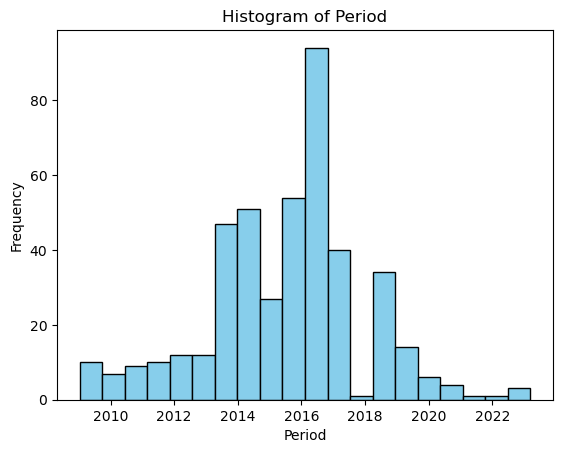

In [985]:
plt.hist(sb_data_n10[sb_data_n10['class']=='trendy']['licence_date'].reset_index(drop=True), bins=20, color='skyblue', edgecolor='black')  # 히스토그램 그리기
plt.xlabel('Period')
plt.ylabel('Frequency')
plt.title('Histogram of Period')
plt.show()

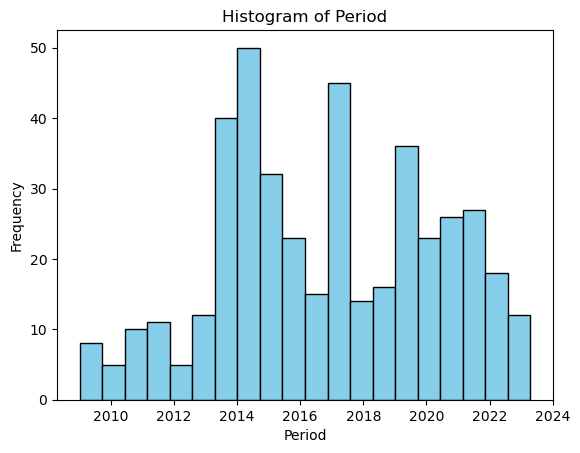

In [986]:
plt.hist(sb_data_n10[sb_data_n10['class']=='steady']['licence_date'].reset_index(drop=True), bins=20, color='skyblue', edgecolor='black')  # 히스토그램 그리기
plt.xlabel('Period')
plt.ylabel('Frequency')
plt.title('Histogram of Period')
plt.show()

In [950]:
scaler = StandardScaler()
scaler.fit(np.array(temp['period']).reshape(-1,1))

StandardScaler()

In [955]:
sb_data_n10['scale'] = scaler.transform(np.array(sb_data_n10['period']).reshape(-1,1)).flatten()
sb_data_not_n10['scale'] = scaler.transform(np.array(sb_data_not_n10['period']).reshape(-1,1)).flatten()

In [929]:
# for steady, trendy in zip(set(sb_data_n10_steady_before['keyword']), set(sb_data_n10_trendy_after['keyword'])):
#     temp = pd.concat([sb_data_n10, sb_data_not_n10], axis=0).reset_index(drop=True)
#     globals()['scaler_{}'.format(steady)] = StandardScaler()
#     globals()['scaler_{}'.format(steady)].fit(np.array(temp[temp['keyword']==steady]['period']).reshape(-1,1))
                                              
#     globals()['scaler_{}'.format(trendy)] = StandardScaler()
#     globals()['scaler_{}'.format(trendy)].fit(np.array(temp[temp['keyword']==trendy]['period']).reshape(-1,1))

# scaler_탕후루 = StandardScaler()
# scaler_탕후루.fit(np.array(temp[temp['keyword']=='탕후루']['period']).reshape(-1,1))


StandardScaler()

In [930]:
# temp = []
# for idx, data in sb_data_n10.iterrows():
#     temp.extend(globals()['scaler_{}'.format(data['keyword'])].transform(np.array(data['period']).reshape(-1,1)).flatten())
# sb_data_n10['scale'] = temp

In [931]:
# temp = []
# for idx, data in sb_data_not_n10.iterrows():
#     temp.extend(globals()['scaler_{}'.format(data['keyword'])].transform(np.array(data['period']).reshape(-1,1)).flatten())
# sb_data_not_n10['scale'] = temp

In [932]:
# sb_data_n10 = sb_data_n10[sb_data_n10['status']=='폐업']
# sb_data_not_n10 = sb_data_not_n10[sb_data_not_n10['status']=='폐업']

In [956]:
sb_data_n10_steady_before = sb_data_n10[(sb_data_n10['keyword']=='명랑핫도그')& (sb_data_n10['licence_date']<boom['명랑핫도그']) 
            | (sb_data_n10['keyword']=='설빙')& (sb_data_n10['licence_date']<boom['설빙'])
           | (sb_data_n10['keyword']=='공차')& (sb_data_n10['licence_date']<boom['공차'])
           | (sb_data_n10['keyword']=='마라탕')& (sb_data_n10['licence_date']<boom['마라탕'])
           | (sb_data_n10['keyword']=='엽기떡볶이')& (sb_data_n10['licence_date']<boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_n10_steady_after = sb_data_n10[(sb_data_n10['keyword']=='명랑핫도그')& (sb_data_n10['licence_date']>=boom['명랑핫도그']) 
            | (sb_data_n10['keyword']=='설빙')& (sb_data_n10['licence_date']>=boom['설빙'])
           | (sb_data_n10['keyword']=='공차')& (sb_data_n10['licence_date']>=boom['공차'])
           | (sb_data_n10['keyword']=='마라탕')& (sb_data_n10['licence_date']>=boom['마라탕'])
           | (sb_data_n10['keyword']=='엽기떡볶이')& (sb_data_n10['licence_date']>=boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_n10_trendy_before = sb_data_n10[(sb_data_n10['keyword']=='카스테라')& (sb_data_n10['licence_date']<boom['카스테라']) 
            | (sb_data_n10['keyword']=='쥬씨')& (sb_data_n10['licence_date']<boom['쥬씨'])
           | (sb_data_n10['keyword']=='엉터리생고기')& (sb_data_n10['licence_date']<boom['엉생'])
           | (sb_data_n10['keyword']=='홍루이젠')& (sb_data_n10['licence_date']<boom['홍루이젠'])
           | (sb_data_n10['keyword']=='밥버거')& (sb_data_n10['licence_date']<boom['밥버거'])].reset_index(drop=True)

sb_data_n10_trendy_after = sb_data_n10[(sb_data_n10['keyword']=='카스테라')& (sb_data_n10['licence_date']>=boom['카스테라']) 
            | (sb_data_n10['keyword']=='쥬씨')& (sb_data_n10['licence_date']>=boom['쥬씨'])
           | (sb_data_n10['keyword']=='엉터리생고기')& (sb_data_n10['licence_date']>=boom['엉생'])
           | (sb_data_n10['keyword']=='홍루이젠')& (sb_data_n10['licence_date']>=boom['홍루이젠'])
           | (sb_data_n10['keyword']=='밥버거')& (sb_data_n10['licence_date']>=boom['밥버거'])].reset_index(drop=True)



In [957]:
sb_data_not_n10_steady_before = sb_data_not_n10[(sb_data_not_n10['keyword']=='명랑핫도그')& (sb_data_not_n10['licence_date']<boom['명랑핫도그']) 
            | (sb_data_not_n10['keyword']=='설빙')& (sb_data_not_n10['licence_date']<boom['설빙'])
           | (sb_data_not_n10['keyword']=='공차')& (sb_data_not_n10['licence_date']<boom['공차'])
           | (sb_data_not_n10['keyword']=='마라탕')& (sb_data_not_n10['licence_date']<boom['마라탕'])
           | (sb_data_not_n10['keyword']=='엽기떡볶이')& (sb_data_not_n10['licence_date']<boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_not_n10_steady_after = sb_data_not_n10[(sb_data_not_n10['keyword']=='명랑핫도그')& (sb_data_not_n10['licence_date']>=boom['명랑핫도그']) 
            | (sb_data_not_n10['keyword']=='설빙')& (sb_data_not_n10['licence_date']>=boom['설빙'])
           | (sb_data_not_n10['keyword']=='공차')& (sb_data_not_n10['licence_date']>=boom['공차'])
           | (sb_data_not_n10['keyword']=='마라탕')& (sb_data_not_n10['licence_date']>=boom['마라탕'])
           | (sb_data_not_n10['keyword']=='엽기떡볶이')& (sb_data_not_n10['licence_date']>=boom['엽기떡볶이'])].reset_index(drop=True)

sb_data_not_n10_trendy_before = sb_data_not_n10[(sb_data_not_n10['keyword']=='카스테라')& (sb_data_not_n10['licence_date']<boom['카스테라']) 
            | (sb_data_not_n10['keyword']=='쥬씨')& (sb_data_not_n10['licence_date']<boom['쥬씨'])
           | (sb_data_not_n10['keyword']=='엉생')& (sb_data_not_n10['licence_date']<boom['엉생'])
           | (sb_data_not_n10['keyword']=='홍루이젠')& (sb_data_not_n10['licence_date']<boom['홍루이젠'])
           | (sb_data_not_n10['keyword']=='밥버거')& (sb_data_not_n10['licence_date']<boom['밥버거'])].reset_index(drop=True)

sb_data_not_n10_trendy_after = sb_data_not_n10[(sb_data_not_n10['keyword']=='카스테라')& (sb_data_not_n10['licence_date']>=boom['카스테라']) 
            | (sb_data_not_n10['keyword']=='쥬씨')& (sb_data_not_n10['licence_date']>=boom['쥬씨'])
           | (sb_data_not_n10['keyword']=='엉생')& (sb_data_not_n10['licence_date']>=boom['엉생'])
           | (sb_data_not_n10['keyword']=='홍루이젠')& (sb_data_not_n10['licence_date']>=boom['홍루이젠'])
           | (sb_data_not_n10['keyword']=='밥버거')& (sb_data_not_n10['licence_date']>=boom['밥버거'])].reset_index(drop=True)

In [958]:
sum(sb_data_n10_steady_before['scale']<0)/len(sb_data_n10_steady_before)

0.4337899543378995

In [959]:
sum(sb_data_n10_steady_after['scale']<0)/len(sb_data_n10_steady_after)

0.7655502392344498

In [960]:
sum(sb_data_n10_trendy_before['scale']<0)/len(sb_data_n10_trendy_before)

0.3984375

In [961]:
sum(sb_data_n10_trendy_after['scale']<0)/len(sb_data_n10_trendy_after)

0.6629834254143646

In [962]:
sb_data_not_n10_steady_before
sum(sb_data_not_n10_steady_before['scale']<0)/len(sb_data_not_n10_steady_before)

0.4362745098039216

In [963]:
sb_data_not_n10_steady_after
sum(sb_data_not_n10_steady_after['scale']<0)/len(sb_data_not_n10_steady_after)

0.782312925170068

In [964]:
sb_data_not_n10_trendy_before
sum(sb_data_not_n10_trendy_before['scale']<0)/len(sb_data_not_n10_trendy_before)

0.4589905362776025

In [966]:
sb_data_not_n10_trendy_after
sum(sb_data_not_n10_trendy_after['scale']<0)/len(sb_data_not_n10_trendy_after)

0.6966824644549763